In [1]:
import sklearn.tree
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/home/benjamin/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/benjamin/venv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
features_pd = pd.read_csv('ring_features.csv.bz2', compression='bz2')
targets_pd = pd.read_csv('ring_targets.csv')
full_pd = features_pd.merge(targets_pd)

features = features_pd.as_matrix()[:,1:]
targets = targets_pd.as_matrix()[:,1:].flatten()
print(features.shape, targets.shape)

(214304, 38) (214304,)


In [3]:
tmask = np.random.choice([False,True], len(targets), p=[0.25, 0.75])
vmask = np.invert(tmask)
train_X = features[tmask]
train_Y = targets[tmask]
test_X = features[vmask]
test_Y = targets[vmask]

print("Training set: {} items, {:.1f}% valuable".format(train_X.shape[0], 100*(sum(train_Y) / train_Y.shape[0])))
print("Validation set: {} items, {:.1f}% valuable".format(test_X.shape[0], 100*(sum(test_Y) / test_Y.shape[0])))

target = 'valuable'
predictors = [x for x in full_pd.columns if x not in [target, 'Unnamed: 0']]


Training set: 160448 items, 38.4% valuable
Validation set: 53856 items, 38.6% valuable


In [ ]:
cv_params = {'max_depth': [7,9,11]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.8, 'objective': 'binary:logistic',
              'scale_pos_weight':1}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), param_grid=cv_params, cv=5, n_jobs=4, iid=False, scoring='roc_auc')
start = timer()
optimized_GBM.fit(train_X, train_Y)
print("Training done after {} seconds".format(timer() - start))

In [5]:
optimized_GBM.grid_scores_, optimized_GBM.best_params_, optimized_GBM.best_score_

([mean: 0.72396, std: 0.00110, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.72402, std: 0.00107, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.72374, std: 0.00120, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.72386, std: 0.00114, params: {'max_depth': 3, 'min_child_weight': 8},
  mean: 0.72403, std: 0.00110, params: {'max_depth': 3, 'min_child_weight': 10},
  mean: 0.73222, std: 0.00078, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.73209, std: 0.00090, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.73213, std: 0.00093, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.73192, std: 0.00103, params: {'max_depth': 5, 'min_child_weight': 8},
  mean: 0.73224, std: 0.00087, params: {'max_depth': 5, 'min_child_weight': 10},
  mean: 0.73581, std: 0.00092, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.73609, std: 0.00080, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.73601, std: 0.00083, params:


Model Report
Accuracy : 0.7315
AUC Score (Train): 0.769893


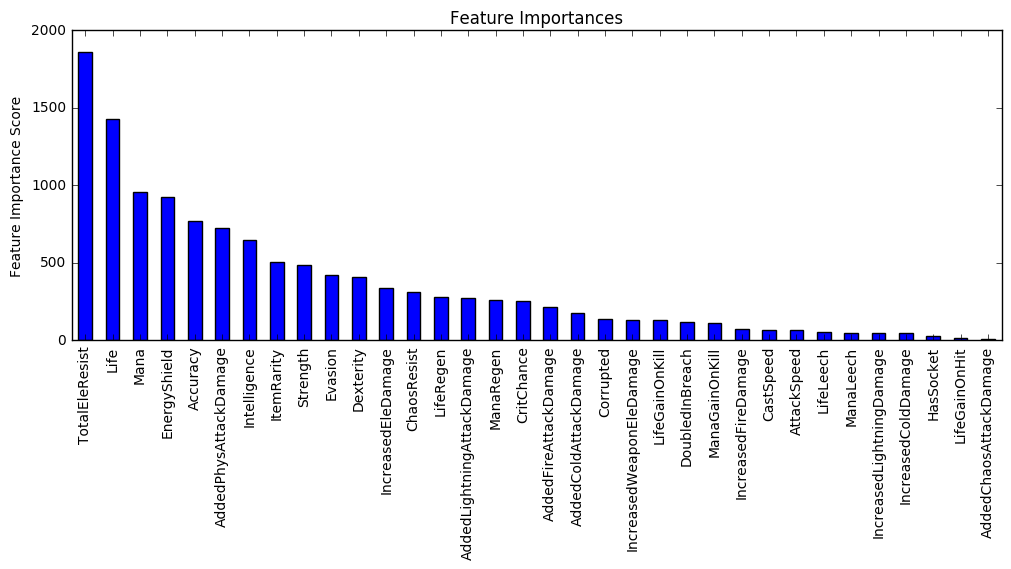

In [7]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

dtrain = full_pd[tmask]
params = {**ind_params, **optimized_GBM.best_params_}
model = xgb.XGBClassifier(**params)
modelfit(model, dtrain, predictors)

Valuable Items Wasted: 12220 (59.4%)
Worthless Items Kept: 3226 (9.9%)
Precision: [ 0.38654356  0.72098253  1.        ]
Recall: [ 1.          0.40552637  0.        ]


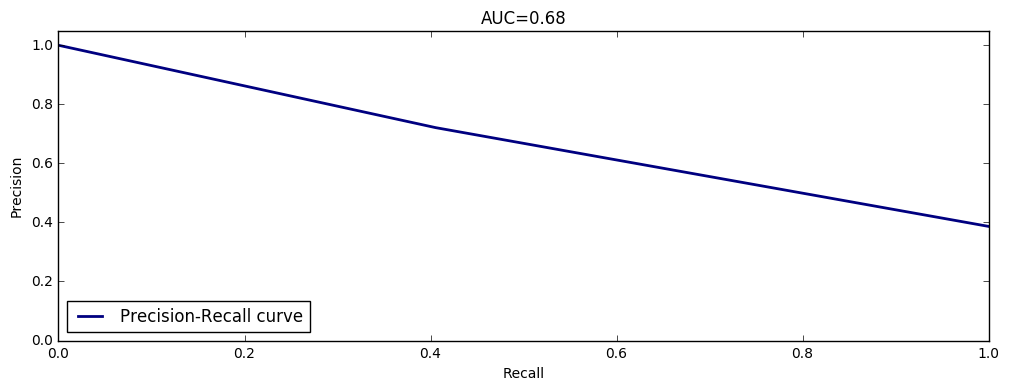

In [32]:
predictions = model.predict(full_pd[vmask][predictors])
ones = np.asarray([1]*predictions.shape[0])
precision, recall, _ = metrics.precision_recall_curve(test_Y, predictions)
average_precision = metrics.average_precision_score(test_Y, predictions)
#precision_micro, recall_micro, _ = metrics.precision_recall_curve(test_Y.ravel(), predictions.ravel())
#average_precision_micro = metrics.average_precision_score(test_Y.ravel(), predictions.ravel(), average='micro')

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
invalid_stuff = 0
for actual, predicted in zip(test_Y, predictions):
    if actual == 1 and predicted == 1:
        true_positives += 1
    elif actual == 0 and predicted == 0:
        true_negatives += 1
    elif actual == 0 and predicted == 1:
        false_positives += 1
    elif actual == 1 and predicted == 0:
        false_negatives += 1
    else:
        invalid_stuff += 1
    
print("Valuable Items Wasted: {} ({:.1f}%)".format(false_negatives, 100*(false_negatives / (false_negatives + true_positives))))
print("Worthless Items Kept: {} ({:.1f}%)".format(false_positives, 100*(false_positives / (false_positives + true_negatives))))

print("Precision:", precision)
print("Recall:", recall)

plt.clf()
plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('AUC={:0.2f}'.format(average_precision))
plt.legend(loc='lower left')
plt.show()

In [ ]:
def modefit(alg, dtrain, dtest, predictors, use_train_cv=True, cv_folds=5, early_stopping_rounds=50):
    if use_train_cv:
        xgb_param = alg.get_xgb_params()
        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    alg.fit(dtrain, )

In [ ]:
model = sklearn.tree.DecisionTreeClassifier(criterion='gini')
model.fit(train_X, train_Y)
model.score(train_X, train_Y)
prediction = model.predict(test_X)


In [ ]:
scale = pd.Series.from_csv('ring_max.csv').as_matrix()

for i,p in enumerate(prediction):
    if p == 1:
        f = test_X[i] * scale
        for j,v in enumerate(f):
            if v > 0:
                print(features_pd.columns[j], v)
        print('------------------------------')
    if i > 10:
        break